# Heat Equation

In this notebook, we will solve the heat equation **numerically**. The heat equation is a partial differential equation (PDE) that describes the evolution of temperature in a medium. It is given by:

$$\frac{\partial u}{\partial t} = \alpha \nabla^2 u$$

where:

* $u$ is the temperature at a given point in space and time
* $t$ is time
* $\alpha$ is the thermal diffusivity
* $\nabla^2$ is the Laplacian operator

The Laplacian operator is defined, in 2D, as:

$$\nabla^2 u = \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2}$$

but in a discretized form, it is:

$$\nabla^2 u = \frac{u_{i-1,j} - 2u_{i,j} + u_{i+1,j}}{\Delta x^2} + \frac{u_{i,j-1} - 2u_{i,j} + u_{i,j+1}}{\Delta y^2}$$

so the discretized heat equation is:

$$\frac{u_j^{m+1}-u_j^m}{\Delta t} = \alpha \left[\frac{u_{i-1,j}^m - 2u_{i,j}^m + u_{i+1,j}^m}{\Delta x^2} + \frac{u_{i,j-1}^m - 2u_{i,j}^m + u_{i,j+1}^m}{\Delta y^2}\right]$$

where $m$ is the time step index and $j$ is the spatial index. So, we can rearrange this to solve for ${m+1}$, and know that $\Delta x = \Delta y$:

$$u_j^{m+1} = u_j^m + \alpha \frac{\Delta t}{\Delta x^2} \left[u_{i-1,j}^m - 2u_{i,j}^m + u_{i+1,j}^m + u_{i,j-1}^m - 2u_{i,j}^m + u_{i,j+1}^m\right]$$

So, we need the following libraries:

* `numpy` for array manipulation
* `matplotlib` for plotting
* `skimage` for image manipulation
* `numba` for just-in-time compilation

In [30]:
import numpy as np # Arrays and matrixes operations
import matplotlib.pyplot as plt # Plot
from matplotlib import animation # Make animation
from mpl_toolkits.mplot3d import Axes3D # 3D view
from matplotlib.animation import PillowWriter # Save video
from matplotlib import cm # Color map
from skimage import color, io # Image manipulation
import numba # Calculations faster
from numba import jit

We need to define our grid

In [31]:
edge = np.linspace(0, 1, 100)
xv, yv = np.meshgrid(edge, edge)

Let's define a rectangle that is the object will miss its heat.

In [82]:
def heat_block(x, y):
    return np.select([(x > 0.4) * (x < 0.6) * (y > 0.4) * (y < 0.6), 
                      (x <= 0.4) + (x >= 0.6) + (y <= 0.4) + (y >= 0.6)], 
                      [0, 1])

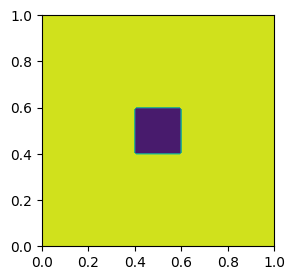

In [83]:
plt.figure(figsize=(3, 3))
plt.contourf(xv, yv, heat_block(xv, yv))

In [84]:
block_bool = heat_block(xv, yv) < 0.9

Now, define the Thermal Diffusivity $\alpha$ of the object.

In [85]:
alpha = 1.32e-7

Define the initial temperature of the object and the surrounding medium.

In [86]:
object_temp = 273.15 + 25
medium_temp = 273.15 + 165

Create the initial temperature field.

In [87]:
init_heat = np.zeros([100, 100]) + medium_temp
init_heat[block_bool] = object_temp

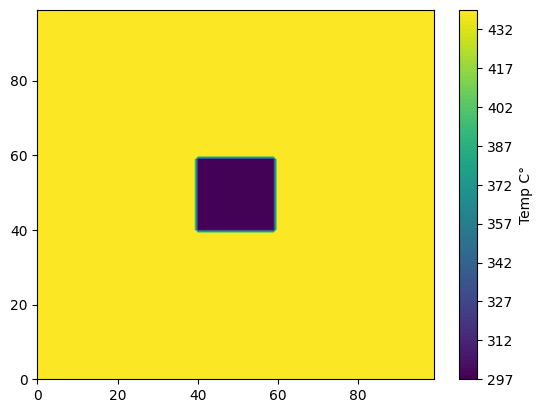

In [88]:
plt.contourf(init_heat, 100)
plt.colorbar(label="Temp C°")

Now we need to define:

* $\Delta t$ - the time step
* `time_snapshots` - the number of time steps to take
* `f` - The interval between snapshots
* `heat_snapshots` - an array to store the snapshots

In [89]:
times = 36_000
times_snapshot = 3_600
f = times // times_snapshot
heat_frames = np.zeros([times_snapshot, 100, 100])
heat_frames[0] = init_heat

Define the dimensions of the grid.

In [90]:
x = 0.5
dx = x / 100
dt = 1

Compute $s = a\Delta t/\Delta x^2$ needs to be much less than $1/4$ for the numerical scheme to be stable.

In [91]:
alpha * dt / (dx)**2 < 0.25

True

Define a function to compute the next time step.

In [92]:
@numba.jit("f8[:,:,:](f8[:,:,:], b1[:,:])", nopython=True, nogil=True)
def solve_heat(heatmap, is_obj):
    cs = heatmap[0].copy() #current state
    length = len(cs[0])
    cf = 0 # current frame
    for t in range(1,times):
        ns = cs.copy() # new state
        for i in range(1, length-1):
            for j in range(1, length-1):
                if is_obj[j][i]:
                    a = alpha
                    ns[j][i] = cs[j][i] + a*dt/dx**2 * (cs[j+1][i] + cs[j-1][i] +\
                                                    cs[j][i+1] + cs[j][i-1] -\
                                                    4*cs[j][i])
        cs = ns.copy()
        if t%f==0:
            cf = cf + 1
            heatmap[cf] = cs
            
    return heatmap

Now we can compute (in Kelvin) the time evolution of the temperature field.

In [93]:
heat_frames = solve_heat(heat_frames, block_bool)

Now let's transform the temperature field into a Celsius scale.

In [94]:
heat_frames -= 273.15

Let's check the last snapshot of the temperature field.

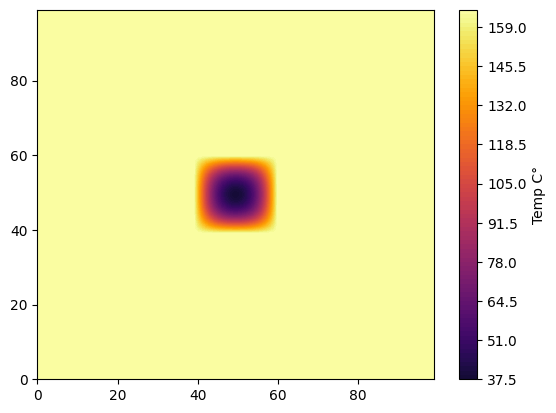

In [95]:
plt.contourf(heat_frames[200], 100, cmap='inferno', vmin=object_temp-273.15, vmax=medium_temp-273.15)
plt.colorbar(label="Temp C°")

Now, we create an animation of the temperature field.

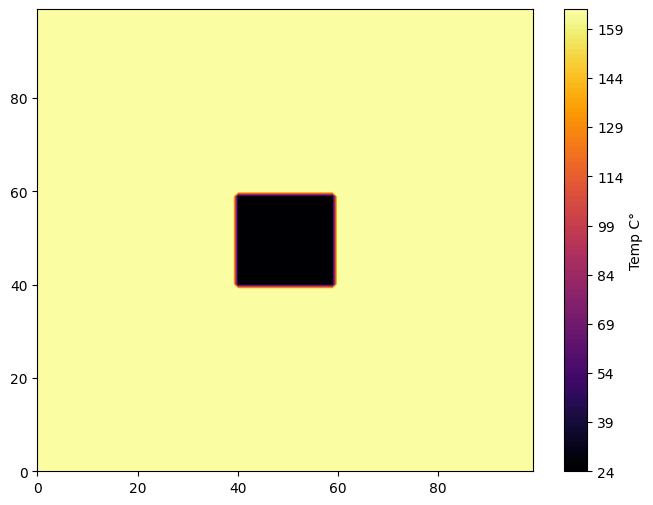

In [96]:
def animate(i):
    ax.clear()
    ax.contourf(heat_frames[10*i], 100, cmap='inferno', vmin=object_temp-273.15, vmax=medium_temp-273.15)
    return fig,

fig, ax = plt.subplots(figsize=(8,6))
axis = ax.contourf(heat_frames[0], 100, cmap='inferno', vmin=object_temp-273.15, vmax=medium_temp-273.15)
fig.colorbar(axis, label="Temp C°")
ani = animation.FuncAnimation(fig, animate,
                               frames=359, interval=50)
ani.save('cooked.gif',writer='pillow',fps=30)

Now, we can plot how temperature changes with time.

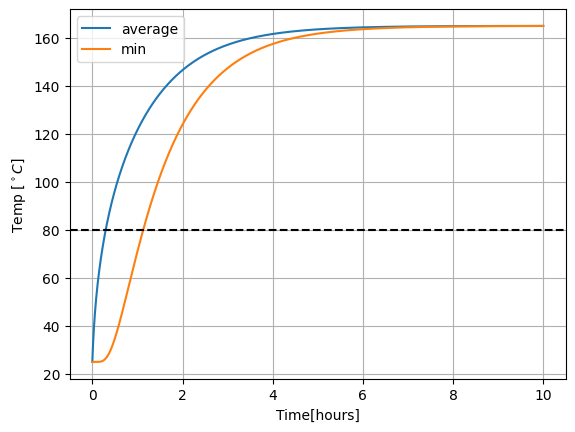

In [97]:
t = np.linspace(0, 10, len(heat_frames))
avg_temp = np.array([heat_frame[block_bool].mean() for heat_frame in heat_frames]) 
min_temp = np.array([heat_frame[block_bool].min() for heat_frame in heat_frames]) 
std_temp = np.array([heat_frame[block_bool].std() for heat_frame in heat_frames]) 

plt.plot(t, avg_temp, label='average')
plt.plot(t, min_temp, label='min')
plt.axhline(80, color='k', ls='--')
plt.xlabel('Time[hours]')
plt.ylabel('Temp [$^\circ C$]')
plt.grid()
plt.legend(loc="best")
